<a href="https://colab.research.google.com/github/makepluscode/tinyml-examples/blob/main/tinyml_ex01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers

In [4]:
# Print versions
!python --versions
print('Numpy' + np.__version__)
print('TensorFlow' + tf.__version__)
print('Keras' + tf.keras.__version__)

unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy1.19.5
TensorFlow2.4.1
Keras2.4.0


In [5]:
nsamples = 1000
val_ratio = 0.2
test_ratio = 0.2
tflite_model_name = 'sine_model'
c_model_name = 'sine_model'

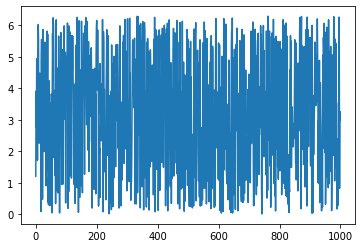

In [6]:
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

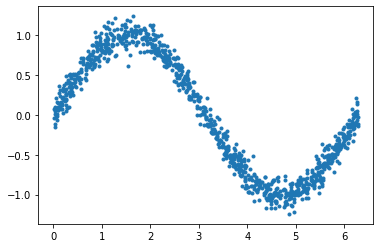

In [7]:
y_values = np.sin(x_values) + (0.1*np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

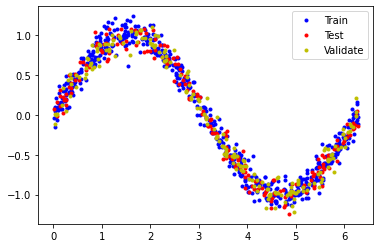

In [8]:
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

assert(x_train.size + x_val.size + x_test.size) == nsamples

plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [10]:
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
6/6 [==============================] - 1s 83ms/step - loss: 0.5633 - mae: 0.5633 - val_loss: 0.5226 - val_mae: 0.5226
Epoch 2/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5531 - mae: 0.5531 - val_loss: 0.5154 - val_mae: 0.5154
Epoch 3/500
6/6 [==============================] - 0s 9ms/step - loss: 0.5544 - mae: 0.5544 - val_loss: 0.5122 - val_mae: 0.5122
Epoch 4/500
6/6 [==============================] - 0s 9ms/step - loss: 0.5533 - mae: 0.5533 - val_loss: 0.5087 - val_mae: 0.5087
Epoch 5/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5310 - mae: 0.5310 - val_loss: 0.5056 - val_mae: 0.5056
Epoch 6/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5303 - mae: 0.5303 - val_loss: 0.5021 - val_mae: 0.5021
Epoch 7/500
6/6 [==============================] - 0s 8ms/step - loss: 0.5175 - mae: 0.5175 - val_loss: 0.4978 - val_mae: 0.4978
Epoch 8/500
6/6 [==============================] - 0s 9ms/step - loss: 0.5148 - mae: 0.5148 - va

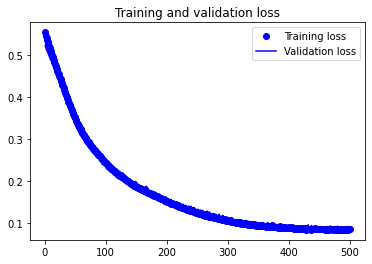

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

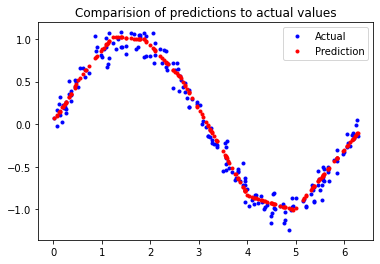

In [14]:
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparision of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label="Prediction")
plt.legend()
plt.show()

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp06x3rq1r/assets


2992

In [23]:
def hex_to_c_arrary(hex_data, var_name):
  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n';

  # Declard c variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    hex_str = format(val, '#04x')

    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  c_str += '\n' + format(''.join(hex_array)) + '\n};\n\n'

  c_str += '#endif //' + var_name.upper() + '_H'
  return c_str


with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_arrary(tflite_model, c_model_name))